<a href="https://colab.research.google.com/github/drpeppurr/yamcha/blob/main/tutorial/YAMCHA_tutorial_ch10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Load packages etc

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import xarray as xr

from scipy.integrate import solve_ivp,cumulative_trapezoid
from scipy import interpolate

# Note: might need to set this high if running very big mechanisms, like the full MCM..
#       3000 seems to be sufficient for full MCM.
# import sys
# sys.setrecursionlimit(3000)

2. These are some functionalities to load/process the KPP files generated from the MCM website: <br>https://mcm.york.ac.uk/MCM <br>
Make sure to check "inorganic chemistry" and the "generic rate coefficients".
<br>

In [3]:
# ======================================
# photolysis frequency (j-value) mapping
# ======================================
kpp_jval_mapping = pd.DataFrame({' J_O3_O1D ': ['J1'],       ' J_O3_O3P ': ['J2'],
                                 ' J_H2O2 ': ['J3'],         ' J_NO2 ': ['J4'],
                                 ' J_NO3_NO ': ['J5'],       ' J_NO3_NO2 ': ['J6'],
                                 ' J_HONO ': ['J7'],         ' J_HNO3 ': ['J8'],
                                 ' J_HCHO_H ': ['J11'],      ' J_HCHO_H2 ': ['J12'],
                                 ' J_CH3CHO ': ['J13'],      ' J_C2H5CHO ': ['J14'],
                                 ' J_C3H7CHO_HCO ': ['J15'], ' J_C3H7CHO_C2H4 ': ['J16'],
                                 ' J_IPRCHO ': ['J17'],      ' J_MACR_HCO ': ['J18'],
                                 ' J_MACR_H ': ['J19'],      ' J_C5HPALD1 ': ['J20'],
                                 ' J_CH3COCH3 ': ['J21'],    ' J_MEK ': ['J22'],
                                 ' J_MVK_CO ': ['J23'],      ' J_MVK_C2H3 ': ['J24'],
                                 ' J_GLYOX_H2 ': ['J31'],    ' J_GLYOX_HCHO ': ['J32'],
                                 ' J_GLYOX_HCO ': ['J33'],   ' J_MGLYOX ': ['J34'],
                                 ' J_BIACET ': ['J35'],      ' J_CH3OOH ': ['J41'],
                                 ' J_CH3NO3 ': ['J51'],      ' J_C2H5NO3 ': ['J52'],
                                 ' J_NC3H7NO3 ': ['J53'],    ' J_IC3H7NO3 ': ['J54'],
                                 ' J_TC4H9NO3 ': ['J55'],    ' J_NOA ': ['J56'],
                                })
kpp_jval_mapping.index = ['J_label']
kpp_jval_mapping.T


# ================================
# this is the main KPP file loader
# ================================
def load_mcm_kpp(in_mcm_kpp):
    f = open(in_mcm_kpp, "r")
    f_contents = f.readlines()
    f.close()
    # --- find the start of mechanism
    for i,l in enumerate(f_contents):
        if ((' RO2 = ' in l) & ('&' in l)) | ((' RO2 = ' in l) & ('C(ind_' in l)):
            ro2_linenum_start = i
            for n,l2 in enumerate(f_contents[ro2_linenum_start+1:]):
                if 'C(ind_' not in l2:
                    ro2_linenum_end = n + ro2_linenum_start
                    break
        if '#EQUATIONS' in l:
            header_linenum = i
            break
    # --- process RO2 list
    try:
        RO2_list = ' '.join(f_contents[ro2_linenum_start:ro2_linenum_end+1])
        RO2_list = RO2_list.replace('\n','').replace('&','').replace(' ','').replace('RO2=','').replace('C(ind_','').replace(')','')
        RO2_list = RO2_list.split('+')
    except: RO2_list = ''
    # --- get id, reactions, and rate coeff
    reaction_ind,reaction,ratecoeff = [],[],[]
    for l in f_contents[header_linenum+1:]:
        if (':' in l) & ((';' in l)):
            reaction_ind.append(l.replace('\t','').split(':')[0].split('>')[0].replace('<',''))  # 20250402: they changed kpp format.. this works for new kpp but not old ones.. perhaps replace {} with <> so it'll retro compatible?
            reaction.append(l.replace('\t','').split(':')[0].split('>')[1])
            ratecoeff.append(l.replace('\t','').split(':')[1].replace(';','').replace('\n',''))
    # --- housekeeping
    reaction_ind = ['R'+str(int(ind)-1) for ind in reaction_ind]
    ratecoeff = [r.replace(' ','') for r in ratecoeff]
    ratecoeff = [r.replace('EXP','np.exp') for r in ratecoeff]
    ratecoeff = [r.replace('TEMP','temp') for r in ratecoeff]
    ratecoeff = [r.replace('D+','e+') for r in ratecoeff]
    ratecoeff = [r.replace('D-','e-') for r in ratecoeff]
    ratecoeff = [r.replace('J(','jval[ ').replace(')',' ]') if 'J(' in r else r for r in ratecoeff]
    ratecoeff2 = []
    for r in ratecoeff: # this is sloppy...
        if 'D' in r:
            loc_of_fucking_D = r.find('D')
            if (r[loc_of_fucking_D-1].isnumeric()) & (r[loc_of_fucking_D+1].isnumeric()):
                ratecoeff2.append(r.replace('D','e'))
            else: ratecoeff2.append(r)
        else: ratecoeff2.append(r)
    ratecoeff = ratecoeff2
    # --- remove hv: 20250402: they changed kpp format..
    reaction2 = []
    for i,r in enumerate(reaction):
        if '+hv' in r.replace(' ',''):
            reaction2.append(' '+r.replace(' ','').replace('+hv','').replace('+',' + ').replace('=',' = ')+' ')
        else: reaction2.append(r)
    reaction = reaction2
    # --- update j-label: this works for new kpp and may also work for old ones..
    for i,r in enumerate(ratecoeff):
        if 'jval[' in r:
            jr_update = r
            for jlabel in kpp_jval_mapping.T['J_label'].index:
                if jlabel in jr_update:
                    jr_update = jr_update.replace(jlabel, kpp_jval_mapping.T['J_label'][ jlabel ].replace('J',''))
            ratecoeff[i] = jr_update
    # --- pack
    mcm_kpp = pd.DataFrame([reaction,ratecoeff,RO2_list]).transpose()
    mcm_kpp.columns = ['reaction', 'rate_coefficient','RO2']
    ChemMech = mcm_kpp.T.copy()
    ChemMech.columns = reaction_ind
    return ChemMech#,RO2_list


3. These are the chemical mechanism parser and related utilities:<br>
- pre_process(...): this processes the mechanism, then generate the derivatives (dC/dt)
- get_jac(...): this calculates the Jacobian matrix. makes the solver faster!
- mcm_jval(...): photolysis frequencies, which are based on MCM (parameterized as a function of solar zenith angle)
- pd_mcm_kinetics(...): generic rate coefficients, also from MCM.

In [4]:
# ================
# Jacobian matrix!
# ================
def get_jac(full_dcodt,rates):
    jac = []
    for i,dcodt in enumerate(full_dcodt):
        rhs_dcodt = dcodt.replace('\n','').replace('\\','').replace(' ','').split('=')[1]
        rhs_dcodt = rhs_dcodt.replace('+',',+').replace('-',',-').split(',')[1:]
        rhs_dcodt2 = [] # convert rates to expressions
        for dcodt in rhs_dcodt:
            # rate_ind = int(dcodt.replace('+rate[','').replace('-rate[','').replace('rate[','').replace(']',''))
            rate_ind = int(dcodt.split('rate[')[1].split(']')[0])
            rhs_dcodt2.append(dcodt.replace('rate['+str(rate_ind)+']', rates[rate_ind]))
        rhs_dcodt = rhs_dcodt2.copy()
        del rhs_dcodt2
        jac_row = []
        for n in range(len(full_dcodt)):
            dfodc = '0.'
            c_n = 'conc['+str(n)+']'
            for dcodt in rhs_dcodt:
                order_c_n = dcodt.split('*').count(c_n)
                if order_c_n==2: dfodc = dfodc + dcodt.split('*')[0]+'*2.*'+c_n
                if order_c_n==1: dfodc = dfodc + dcodt.replace('*'+c_n,'')
            if (dfodc!='0.'): jac_row.append('jac_out[%d,%d] = %s' % (i,n,dfodc))
        jac.append('\n'.join(jac_row))
    return '\n'.join(jac)

# =================================
# this procedure does two things:
#  - process the chemical mechanism
#  - generate the "derivatives"
# =================================
def pre_process(in_ChemMech, diagnostic=False):
    line_limit_rate_expres = 60  #...so we don't end up with ridiculously long lines...
    # --- clean up reactions
    reactions = [in_ChemMech[rnd]['reaction'] for rnd in in_ChemMech.columns]
    reactions = [' '+rnd.replace(' ','')+' ' for rnd in reactions]
    reactions = [rnd.replace('+',' + ') for rnd in reactions]
    reactions = [rnd.replace('=',' = ') for rnd in reactions]
    # --- rate coefficient expressions
    rate_coeff_express_2eval = [str(in_ChemMech[rnd]['rate_coefficient']) for rnd in in_ChemMech.columns]
    rate_coeff_express_2eval = [r.replace('EXP','np.exp') for r in rate_coeff_express_2eval]
    rate_coeff_express_2eval = [r.replace('TEMP','temp') for r in rate_coeff_express_2eval]
    rate_coeff_express_2eval = [r.replace('^','**') for r in rate_coeff_express_2eval]
    # --- generate species list based on that
    species_temp = ','.join(reactions)                                 # concatenate
    species_temp = species_temp.replace(' ','')                        # remove all spaces
    for s in ['+','=','*']: species_temp = species_temp.replace(s,',') # chop chop
    species_temp = list(np.unique(species_temp.split(',')))            # keep only unique stuff
    species_list = []
    for spc in species_temp:
        if (spc.replace('.','').isnumeric()==False) & (len(spc)>0): species_list.append(spc) # delete numerical (stoichiometric coefficients)
    # --- now process RO2 list
    RO2_sum = 'RO2=0.0'
    if 'RO2' in in_ChemMech.T.columns:
        RO2_list = [r for r in list(in_ChemMech.T['RO2']) if r]
        linelength_current_RO2 = 0
        if (len(RO2_list)>0):
            for RO2 in RO2_list:
                if (linelength_current_RO2<=line_limit_rate_expres):
                    linelength_current_RO2 = linelength_current_RO2 + len('+conc[' + str(species_list.index(RO2)) + ']')
                    RO2_sum = RO2_sum + '+conc[' + str(species_list.index(RO2)) + ']'
                else:
                    linelength_current_RO2 = 0
                    RO2_sum = RO2_sum + '\ \n' + '+conc[' + str(species_list.index(RO2)) + ']'
        RO2_sum = RO2_sum.replace('\ ','\\')
    if (diagnostic): print(RO2_sum)
    # ===============================================================
    # Okay this generates the derivatives, and save as a list strings
    # then these are "evaluated" and recognized as math expressions
    # ===============================================================
    # --- generate the rates for each reaction
    rates_2eval = []
    for ind_reac,reaction in enumerate(reactions):
        all_reactants = [r.replace(' ','') for r in reaction.split(' = ')[0].split(' + ')]
        # --- 20250407: add support for zero-order reactions
        if len(''.join(all_reactants).replace(' ',''))!=0:    # non-zero order reactions
            all_reactants_conc = ['conc['+str(species_list.index(r))+']' for r in all_reactants]
            rates_2eval.append('rate_coeff[' +str(ind_reac) + ']*' + '*'.join(all_reactants_conc))
        else:                                                 # zero order reactions
            all_reactants_conc = ''
            rates_2eval.append('rate_coeff[' +str(ind_reac) + ']')
    # --- generate the derivative for each compound
    derivatives_expres_2eval = []
    full_dcodt_out = []
    for ind_spc,spc in enumerate(species_list):
        dcodt_spc = '0.'
        lengh_rate_expres_currentline = 0
        if (diagnostic): print('# ---')
        if (diagnostic): print('# ', spc)
        for ind_reac,reaction in enumerate(reactions):
            loc_spc = reaction.replace('*',' ').find(' '+spc+' ')
            # --- only do these if found this compound in this reaction
            if loc_spc>=0:
                all_reactants = [r.replace(' ','') for r in reaction.split(' = ')[0].split(' + ')]
                all_products = [r.replace(' ','') for r in reaction.split(' = ')[1].split(' + ')]
                # --- get rid of stoichiometric coefficients
                all_reactants_nostoic, all_products_nostoic = [],[]
                for s in all_reactants:
                    if s.find('*')>=0: all_reactants_nostoic.append(s.split('*')[1])
                    else: all_reactants_nostoic.append(s)
                for s in all_products:
                    if s.find('*')>=0: all_products_nostoic.append(s.split('*')[1])
                    else: all_products_nostoic.append(s)
                # print(all_reactants, all_products, all_products_nostoic)
                # --- get stoiciometric coefficients
                reaction_temp = reaction.replace(' ','')
                for s in ['+','=']: reaction_temp = reaction_temp.replace(s,',') # chop chop
                reaction_temp = reaction_temp.split(',')
                reaction_stoic = []
                for s in reaction_temp:
                    if s.find('*')>=0: reaction_stoic.append(float(s.split('*')[0]))
                    else: reaction_stoic.append(1)
                # --- overall loc for the species in this reaction
                reaction_temp2 = [] # without stoichiometric coefficient
                for s in reaction_temp:
                    if s.find('*')>=0: reaction_temp2.append(s.split('*')[1])
                    else: reaction_temp2.append(s)
                # --- get rate expression for each reaction
                rate_expres = ''
                # for n_reactant,reactant in enumerate(reaction.split(' = ')[0].split(' + ')):
                #     ind_reactant = species_list.index(reactant.replace(' ',''))
                #     rate_expres = rate_expres + '*conc[%d]' % (ind_reactant)
                # rate_expres = 'rate_coeff[' +str(ind_reac) + ']' + rate_expres
                rate_expres = 'rate[' +str(ind_reac) + ']' # + rate_expres
                # --- check if spc is a reactant or a product, then put everything together
                stoic = reaction_stoic[reaction_temp2.index(spc)]
                for (reactants_or_products,sign) in zip([all_reactants_nostoic,all_products_nostoic],['-','+']):
                    for s in reactants_or_products:
                        if (s==spc): # need to search for all entrys!!!
                            # --- line length constrain
                            if (lengh_rate_expres_currentline>=line_limit_rate_expres):
                                dcodt_spc = dcodt_spc + '   \ \n'
                                lengh_rate_expres_currentline = 0
                            # --- now make the rate extression
                            if (stoic==1.):
                                dcodt_spc = dcodt_spc + sign + rate_expres
                                lengh_rate_expres_currentline = lengh_rate_expres_currentline + len(rate_expres)
                            else:
                                dcodt_spc = dcodt_spc + sign + str(stoic) + '*' + rate_expres
                                lengh_rate_expres_currentline = lengh_rate_expres_currentline + len(rate_expres)
        # --- output
        full_dcodt = 'dcodt_out[%d] = %s' % (ind_spc,dcodt_spc)
        full_dcodt = full_dcodt.replace('\ ','\\')
        # full_dcodt_out = full_dcodt_out + full_dcodt +'\n'
        full_dcodt_out.append(full_dcodt)
        if (diagnostic): print(full_dcodt)
        derivatives_expres_2eval.append(dcodt_spc.replace('\ ','\\'))
    # --- now get the jacobian metrix
    jac_2eval = get_jac(full_dcodt_out,rates_2eval)
    return species_list, reactions, rates_2eval, derivatives_expres_2eval, rate_coeff_express_2eval, jac_2eval, RO2_sum


def mcm_jval(SZA):
    jval = np.zeros(100)
    jval[1] = 6.073E-05*np.cos(SZA)**1.743*np.exp(-1*0.474*np.cos(SZA)**-1)
    jval[2] = 4.775E-04*np.cos(SZA)**0.298*np.exp(-1*0.08*np.cos(SZA)**-1)
    jval[3] = 1.041E-05*np.cos(SZA)**0.723*np.exp(-1*0.279*np.cos(SZA)**-1)
    jval[4] = 1.165E-02*np.cos(SZA)**0.244*np.exp(-1*0.267*np.cos(SZA)**-1)
    jval[5] = 2.485E-02*np.cos(SZA)**0.168*np.exp(-1*0.108*np.cos(SZA)**-1)
    jval[6] = 1.747E-01*np.cos(SZA)**0.155*np.exp(-1*0.125*np.cos(SZA)**-1)
    jval[7] = 2.644E-03*np.cos(SZA)**0.261*np.exp(-1*0.288*np.cos(SZA)**-1)
    jval[8] = 9.312E-07*np.cos(SZA)**1.23*np.exp(-1*0.307*np.cos(SZA)**-1) # HNO3
    jval[11] = 4.642E-05*np.cos(SZA)**0.762*np.exp(-1*0.353*np.cos(SZA)**-1)
    jval[12] = 6.853E-05*np.cos(SZA)**0.477*np.exp(-1*0.323*np.cos(SZA)**-1)
    jval[13] = 7.344E-06*np.cos(SZA)**1.202*np.exp(-1*0.417*np.cos(SZA)**-1)
    jval[14] = 2.879E-05*np.cos(SZA)**1.067*np.exp(-1*0.358*np.cos(SZA)**-1)
    jval[15] = 2.792E-05*np.cos(SZA)**0.805*np.exp(-1*0.338*np.cos(SZA)**-1)
    jval[16] = 1.675E-05*np.cos(SZA)**0.805*np.exp(-1*0.338*np.cos(SZA)**-1)
    jval[17] = 7.914E-05*np.cos(SZA)**0.764*np.exp(-1*0.364*np.cos(SZA)**-1)
    jval[18] = 1.482E-06*np.cos(SZA)**0.396*np.exp(-1*0.298*np.cos(SZA)**-1)
    jval[19] = 1.482E-06*np.cos(SZA)**0.396*np.exp(-1*0.298*np.cos(SZA)**-1)
    jval[20] = 7.600E-04*np.cos(SZA)**0.396*np.exp(-1*0.298*np.cos(SZA)**-1)
    jval[21] = 7.992E-07*np.cos(SZA)**1.578*np.exp(-1*0.271*np.cos(SZA)**-1)
    jval[22] = 5.804E-06*np.cos(SZA)**1.092*np.exp(-1*0.377*np.cos(SZA)**-1)
    jval[23] = 2.4246E-06*np.cos(SZA)**0.395*np.exp(-1*0.296*np.cos(SZA)**-1)
    jval[24] = 2.424E-06*np.cos(SZA)**0.395*np.exp(-1*0.296*np.cos(SZA)**-1)
    jval[31] = 6.845E-05*np.cos(SZA)**0.13*np.exp(-1*0.201*np.cos(SZA)**-1)
    jval[32] = 1.032E-05*np.cos(SZA)**0.13*np.exp(-1*0.201*np.cos(SZA)**-1)
    jval[33] = 3.802E-05*np.cos(SZA)**0.644*np.exp(-1*0.312*np.cos(SZA)**-1)
    jval[34] = 1.537E-04*np.cos(SZA)**0.17*np.exp(-1*0.208*np.cos(SZA)**-1)
    jval[35] = 3.326E-04*np.cos(SZA)**0.148*np.exp(-1*0.215*np.cos(SZA)**-1)
    jval[41] = 7.649E-06*np.cos(SZA)**0.682*np.exp(-1*0.279*np.cos(SZA)**-1)
    jval[51] = 1.588E-06*np.cos(SZA)**1.154*np.exp(-1*0.318*np.cos(SZA)**-1) # CH3NO3
    jval[52] = 1.907E-06*np.cos(SZA)**1.244*np.exp(-1*0.335*np.cos(SZA)**-1)
    jval[53] = 2.485E-06*np.cos(SZA)**1.196*np.exp(-1*0.328*np.cos(SZA)**-1)
    jval[54] = 4.095E-06*np.cos(SZA)**1.111*np.exp(-1*0.316*np.cos(SZA)**-1)
    jval[55] = 1.135E-05*np.cos(SZA)**0.974*np.exp(-1*0.309*np.cos(SZA)**-1)
    jval[56] = 4.365E-05*np.cos(SZA)**1.089*np.exp(-1*0.323*np.cos(SZA)**-1)
    jval[61] = 7.537E-04*np.cos(SZA)**0.499*np.exp(-1*0.266*np.cos(SZA)**-1)
    return jval

# --- pulled from MCM website...
def pd_mcm_kinetics(temp,M,N2,O2,H2O,NO=0.,HO2=0.,RO2=0.,NO3=0.):
    KRO2NO = 2.7e-12*np.exp(360/temp)
    KRO2HO2 = 2.91e-13*np.exp(1300/temp)
    KAPHO2 = 5.2e-13*np.exp(980/temp)
    KAPNO = 7.5e-12*np.exp(290/temp)
    KRO2NO3 = 2.3e-12
    KNO3AL = 1.44e-12*np.exp(-1862/temp)
    KDEC = 1.00e+06
    KROPRIM = 2.50e-14*np.exp(-300/temp)
    KROSEC = 2.50e-14*np.exp(-300/temp)
    KCH3O2 = 1.03e-13*np.exp(365/temp)
    K298CH3O2 = 3.5e-13
    K14ISOM1 = 3.00e+7*np.exp(-5300/temp)
    KD0 = 1.10e-05*M*np.exp(-10100/temp)
    KDI = 1.90e+17*np.exp(-14100/temp)
    KRD = KD0/KDI
    FCD = 0.30
    NCD = 0.75-1.27*(np.log10(FCD))
    FD = 10**(np.log10(FCD)/(1+(np.log10(KRD)/NCD)**2))
    KBPAN = (KD0*KDI)*FD/(KD0+KDI)
    KC0 = 3.28e-28*M*(temp/300)**-6.87
    KCI = 1.125e-11*(temp/300)**-1.105
    KRC = KC0/KCI
    FCC = 0.30
    NC = 0.75-1.27*(np.log10(FCC))
    FC = 10**(np.log10(FCC)/(1+(np.log10(KRC)/NC)**2))
    KFPAN = (KC0*KCI)*FC/(KC0+KCI)
    K10 = 1.0e-31*M*(temp/300)**-1.6
    K1I = 5.0e-11*(temp/300)**-0.3
    KR1 = K10/K1I
    FC1 = 0.85
    NC1 = 0.75-1.27*(np.log10(FC1))
    F1 = 10**(np.log10(FC1)/(1+(np.log10(KR1)/NC1)**2))
    KMT01 = (K10*K1I)*F1/(K10+K1I)
    K20 = 1.3e-31*M*(temp/300)**-1.5
    K2I = 2.3e-11*(temp/300)**0.24
    KR2 = K20/K2I
    FC2 = 0.6
    NC2 = 0.75-1.27*(np.log10(FC2))
    F2 = 10**(np.log10(FC2)/(1+(np.log10(KR2)/NC2)**2))
    KMT02 = (K20*K2I)*F2/(K20+K2I)
    K30 = 3.6e-30*M*(temp/300)**-4.1
    K3I = 1.9e-12*(temp/300)**0.2
    KR3 = K30/K3I
    FC3 = 0.35
    NC3 = 0.75-1.27*(np.log10(FC3))
    F3 = 10**(np.log10(FC3)/(1+(np.log10(KR3)/NC3)**2))
    KMT03 = (K30*K3I)*F3/(K30+K3I)
    K40 = 1.3e-3*M*(temp/300)**-3.5*np.exp(-11000/temp)
    K4I = 9.7e+14*(temp/300)**0.1*np.exp(-11080/temp)
    KR4 = K40/K4I
    FC4 = 0.35
    NC4 = 0.75-1.27*(np.log10(FC4))
    F4 = 10**(np.log10(FC4)/(1+(np.log10(KR4)/NC4)**2))
    KMT04 = (K40*K4I)*F4/(K40+K4I)
    KMT05 = 1.44e-13*(1+(M/4.2e+19))
    KMT06 = 1 + (1.40e-21*np.exp(2200/temp)*H2O)
    K70 = 7.4e-31*M*(temp/300)**-2.4
    K7I = 3.3e-11*(temp/300)**-0.3
    KR7 = K70/K7I
    FC7 = 0.81
    NC7 = 0.75-1.27*(np.log10(FC7))
    F7 = 10**(np.log10(FC7)/(1+(np.log10(KR7)/NC7)**2))
    KMT07 = (K70*K7I)*F7/(K70+K7I)
    K80 = 3.2e-30*M*(temp/300)**-4.5
    K8I = 3.0e-11
    KR8 = K80/K8I
    FC8 = 0.41
    NC8 = 0.75-1.27*(np.log10(FC8))
    F8 = 10**(np.log10(FC8)/(1+(np.log10(KR8)/NC8)**2))
    KMT08 = (K80*K8I)*F8/(K80+K8I)
    K90 = 1.4e-31*M*(temp/300)**-3.1
    K9I = 4.0e-12
    KR9 = K90/K9I
    FC9 = 0.4
    NC9 = 0.75-1.27*(np.log10(FC9))
    F9 = 10**(np.log10(FC9)/(1+(np.log10(KR9)/NC9)**2))
    KMT09 = (K90*K9I)*F9/(K90+K9I)
    K100 = 4.10e-05*M*np.exp(-10650/temp)
    K10I = 6.0e+15*np.exp(-11170/temp)
    KR10 = K100/K10I
    FC10 = 0.4
    NC10 = 0.75-1.27*(np.log10(FC10))
    F10 = 10**(np.log10(FC10)/(1+(np.log10(KR10)/NC10)**2))
    KMT10 = (K100*K10I)*F10/(K100+K10I)
    K1 = 2.40e-14*np.exp(460/temp)
    K3 = 6.50e-34*np.exp(1335/temp)
    K4 = 2.70e-17*np.exp(2199/temp)
    K2 = (K3*M)/(1+(K3*M/K4))
    KMT11 = K1 + K2
    K120 = 2.5e-31*M*(temp/300)**-2.6
    K12I = 2.0e-12
    KR12 = K120/K12I
    FC12 = 0.53
    NC12 = 0.75-1.27*(np.log10(FC12))
    F12 = 10**(np.log10(FC12)/(1.0+(np.log10(KR12)/NC12)**2))
    KMT12 = (K120*K12I*F12)/(K120+K12I)
    K130 = 2.5e-30*M*(temp/300)**-5.5
    K13I = 1.8e-11
    KR13 = K130/K13I
    FC13 = 0.36
    NC13 = 0.75-1.27*(np.log10(FC13))
    F13 = 10**(np.log10(FC13)/(1+(np.log10(KR13)/NC13)**2))
    KMT13 = (K130*K13I)*F13/(K130+K13I)
    K140 = 9.0e-5*np.exp(-9690/temp)*M
    K14I = 1.1e+16*np.exp(-10560/temp)
    KR14 = K140/K14I
    FC14 = 0.36
    NC14 = 0.75-1.27*(np.log10(FC14))
    F14 = 10**(np.log10(FC14)/(1+(np.log10(KR14)/NC14)**2))
    KMT14 = (K140*K14I)*F14/(K140+K14I)
    K150 = 8.6e-29*M*(temp/300)**-3.1
    K15I = 9.0e-12*(temp/300)**-0.85
    KR15 = K150/K15I
    FC15 = 0.48
    NC15 = 0.75-1.27*(np.log10(FC15))
    F15 = 10**(np.log10(FC15)/(1+(np.log10(KR15)/NC15)**2))
    KMT15 = (K150*K15I)*F15/(K150+K15I)
    K160 = 8e-27*M*(temp/300)**-3.5
    K16I = 3.0e-11*(temp/300)**-1
    KR16 = K160/K16I
    FC16 = 0.5
    NC16 = 0.75-1.27*(np.log10(FC16))
    F16 = 10**(np.log10(FC16)/(1+(np.log10(KR16)/NC16)**2))
    KMT16 = (K160*K16I)*F16/(K160+K16I)
    K170 = 5.0e-30*M*(temp/300)**-1.5
    K17I = 1.0e-12
    KR17 = K170/K17I
    FC17 = 0.17*np.exp(-51/temp)+np.exp(-temp/204)
    NC17 = 0.75-1.27*(np.log10(FC17))
    F17 = 10**(np.log10(FC17)/(1.0+(np.log10(KR17)/NC17)**2))
    KMT17 = (K170*K17I*F17)/(K170+K17I)
    KMT18 = 9.5e-39*O2*np.exp(5270/temp)/(1+7.5e-29*O2*np.exp(5610/temp))
    KPPN0 = 1.7e-03*np.exp(-11280/temp)*M
    KPPNI = 8.3e+16*np.exp(-13940/temp)
    KRPPN = KPPN0/KPPNI
    FCPPN = 0.36
    NCPPN = 0.75-1.27*(np.log10(FCPPN))
    FPPN = 10**(np.log10(FCPPN)/(1+(np.log10(KRPPN)/NCPPN)**2))
    KBPPN = (KPPN0*KPPNI)*FCPPN/(KPPN0+KPPNI)
    KNO = KRO2NO*NO
    KHO2 = KRO2HO2*HO2*0.706
    KRO2 = 1.26e-12*RO2
    KNO3 = KRO2NO3*NO3
    KTR = KNO + KHO2 + KRO2 + KNO3
    K16ISOM = (KTR*5.18e-04*np.exp(1308/temp)) +(2.76e+07*np.exp(-6759/temp))
    # --- pack... this is a bit sloppy
    k_val = [KRO2NO,KRO2HO2,KAPHO2,KAPNO,KRO2NO3,KNO3AL,KDEC,KROPRIM,KROSEC,KCH3O2,K298CH3O2,K14ISOM1,KBPAN,KFPAN,
             KMT01,KMT02,KMT03,KMT04,KMT05,KMT06,KMT07,KMT08,
             KMT09,KMT10,KMT11,KMT12,KMT13,KMT14,KMT15,KMT16,KMT17,KMT18,KPPN0,KPPNI,KRPPN,FCPPN,NCPPN,FPPN,KBPPN,
             KNO,KHO2,KRO2,KNO3,KTR,K16ISOM]
    k_label = ['KRO2NO','KRO2HO2','KAPHO2','KAPNO','KRO2NO3','KNO3AL','KDEC','KROPRIM','KROSEC','KCH3O2','K298CH3O2','K14ISOM1',
               'KBPAN','KFPAN','KMT01','KMT02','KMT03','KMT04',
               'KMT05','KMT06','KMT07','KMT08','KMT09','KMT10','KMT11','KMT12','KMT13','KMT14','KMT15','KMT16','KMT17',
               'KMT18','KPPN0','KPPNI','KRPPN','FCPPN','NCPPN','FPPN','KBPPN','KNO','KHO2','KRO2','KNO3','KTR','K16ISOM']
    mcm_kin = pd.DataFrame(k_val,index=None).transpose()
    mcm_kin.columns = k_label
    return mcm_kin

# start_time = time.time()
# in_ChemMech = ChemMech
# # in_ChemMech = ChemMech_MCM_inorg
# species_list, reactions, rate_expres_2eval, rate_coeff_express_2eval, jac, RO2_sum = pre_process(in_ChemMech, True)
# species_list, reactions, rates_2eval, derivatives_expres_2eval, rate_coeff_express_2eval, jac_2eval, RO2_sum = pre_process(in_ChemMech)
# print(len(species_list))
# print('Done processing the mechanism in: %.6f seconds' % (time.time() - start_time))

<br>

---


4. Now need to load the chemical mechanism.<br>
You can load the KPP file generated from the MCM website (https://mcm.york.ac.uk/MCM) using the utility provided above.<br>
Note that KPP has multiple different "flavors", e.g. KPP files used in WRF-Chem and GEOS-Chem may look slightly different.<br>
Currently only KPP files from MCM will be supported, but adding support for other KPP files shouldn't be that different. Will follow up later.

In [5]:
# ==========================================================
# Use this to load the chemical mechanism file in KPP format
# ==========================================================
# ChemMech = load_mcm_kpp('/content/mcm_export_isoprene.eqn')
# ChemMech = load_mcm_kpp('/content/mcm_export_ch4.eqn')
ChemMech = load_mcm_kpp('/content/cri_export_C1_C3_Isop_Aromatics.eqn')

ChemMech.T

,reaction,rate_coefficient,RO2
R0,CH4 + OH = CH3O2,1.85E-12*np.exp(-1690./temp),CH3O2
R1,C2H6 + OH = C2H5O2,6.9E-12*np.exp(-1000./temp),C2H5O2
R2,C3H8 + OH = IC3H7O2,7.6E-12*np.exp(-585./temp)*0.736,IC3H7O2
R3,C3H8 + OH = RN10O2,7.6E-12*np.exp(-585./temp)*0.264,RN10O2
R4,C5H8 + OH = RU14O2,2.70E-11*np.exp(390./temp),RU14O2
...,...,...,...
R420,NO3 = NO2 + O,jval[6],None
R421,HONO = NO + OH,jval[7],None
R422,HNO3 = NO2 + OH,jval[8],None
R423,N2O5 = NO2 + NO3,KMT04,None


5. Here let's setup the emissions and depositions as reactions, and then merge with the main mechanism.

In [6]:
ChemMech_EmisDep = pd.DataFrame({'E0': [' = C5H8', 'emission_rate_isoprene_molec_cm3_s', None],
                                 'E1': [' = CO', 'emission_rate_CO_molec_cm3_s', None],
                                 'E2': [' = NO', 'emission_rate_NO_molec_cm3_s', None],
                                 'E3': [' = C2H6', 'emission_rate_C2H6_molec_cm3_s', None],
                                 'E4': [' = C3H8', 'emission_rate_C3H8_molec_cm3_s', None],
                                 'E5': [' = BENZENE', 'emission_rate_benzene_molec_cm3_s', None],
                                 'E6': [' = TOLUENE', 'emission_rate_toluene_molec_cm3_s', None],
                                 'D0': ['O3 = ',  'dep_rate_O3_sec', None],
                                 'D1': ['NO2 = ',  'dep_rate_NO2_sec', None],
                             })
ChemMech_EmisDep.index = ['reaction', 'rate_coefficient', 'RO2']

ChemMech_EmisDep.T

,reaction,rate_coefficient,RO2
E0,= C5H8,emission_rate_isoprene_molec_cm3_s,None
E1,= CO,emission_rate_CO_molec_cm3_s,None
E2,= NO,emission_rate_NO_molec_cm3_s,None
E3,= C2H6,emission_rate_C2H6_molec_cm3_s,None
E4,= C3H8,emission_rate_C3H8_molec_cm3_s,None
E5,= BENZENE,emission_rate_benzene_molec_cm3_s,None
E6,= TOLUENE,emission_rate_toluene_molec_cm3_s,None
D0,O3 =,dep_rate_O3_sec,None
D1,NO2 =,dep_rate_NO2_sec,None


In [7]:
ChemMech_merge = pd.concat([ChemMech,ChemMech_EmisDep],axis=1)
ChemMech_merge.T

,reaction,rate_coefficient,RO2
R0,CH4 + OH = CH3O2,1.85E-12*np.exp(-1690./temp),CH3O2
R1,C2H6 + OH = C2H5O2,6.9E-12*np.exp(-1000./temp),C2H5O2
R2,C3H8 + OH = IC3H7O2,7.6E-12*np.exp(-585./temp)*0.736,IC3H7O2
R3,C3H8 + OH = RN10O2,7.6E-12*np.exp(-585./temp)*0.264,RN10O2
R4,C5H8 + OH = RU14O2,2.70E-11*np.exp(390./temp),RU14O2
...,...,...,...
E4,= C3H8,emission_rate_C3H8_molec_cm3_s,None
E5,= BENZENE,emission_rate_benzene_molec_cm3_s,None
E6,= TOLUENE,emission_rate_toluene_molec_cm3_s,None
D0,O3 =,dep_rate_O3_sec,None


6. Setup model vertical grid!

In [8]:
# --- height grid: layer center
model_top_m = 5000.
dz_m = 100
# dz_m = 200
z_m = np.arange(dz_m/2, model_top_m+dz_m, dz_m)
nlev = len(z_m)

# --- height grid: layer interface
z_interface_m = np.zeros(len(z_m)+1)
for i in range(len(z_interface_m)):
    if i==0: z_interface_m[i] = 0
    else: z_interface_m[i] = 2.*(z_m[i-1]-z_interface_m[i-1])+z_interface_m[i-1]

print('%d vertical layers' % (nlev))


51 vertical layers


7. Read the netcdf file containing information extracted from HRRR.<br>
To drive the 1D model, we need the vertical profiles of temperature, pressure, and specific humidity.<br>
We also need 10-m wind, planetary boundary layer height, and sensible heat flux to calculate the height-dependent eddy diffusivity (Kz).<br>
I picked a random spot in the HRRR domain, and grabbed these info every 3 hours.<br>
These variables need to be interpolated to the model vertical grid and model timestamps, which will be taken care of later.<br>
HRRR data can be obtained from AWS. You can use other models as well.

In [9]:
hrrr = xr.open_dataset('/content/hrrr_info_for_1D_model.nc')
hrrr

<xarray.Dataset> Size: 8kB
Dimensions:     (itime: 9, ilev: 50)
Coordinates:
  * itime       (itime) int32 36B 0 3 6 9 12 15 18 21 24
  * ilev        (ilev) int32 200B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
Data variables:
    press_Pa    (itime, ilev) float32 2kB ...
    temp_K      (itime, ilev) float32 2kB ...
    spfh_kg_kg  (itime, ilev) float32 2kB ...
    height_m    (itime, ilev) float32 2kB ...
    fcst_hr     (itime) int32 36B ...
    pblh_m      (itime) float32 36B ...
    hfx_W_m2    (itime) float32 36B ...
    u10_m_s     (itime) float64 72B ...
Attributes:
    hrrr_init_yyyymmdd:  20240601
    hrrr_init_h:         6
    hrrr_loc_lat:        39.7392
    hrrr_loc_lon:        -104.9903

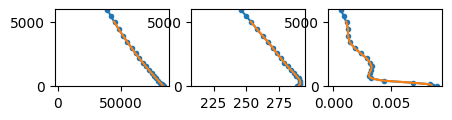

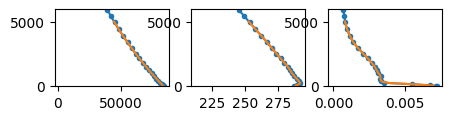

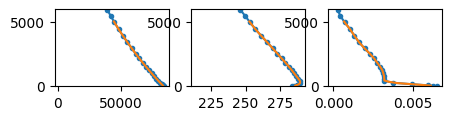

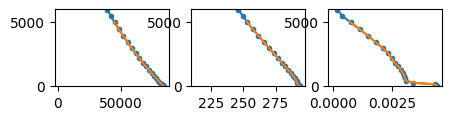

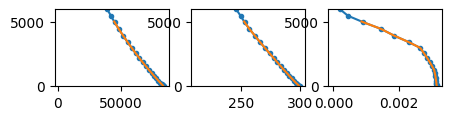

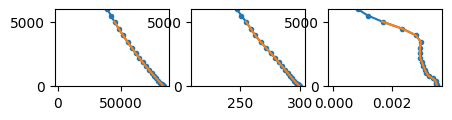

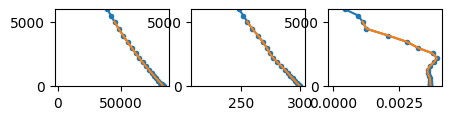

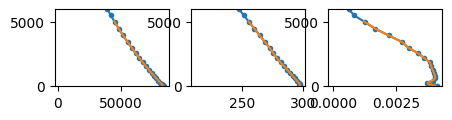

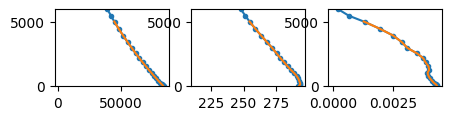

In [10]:
# =====================================================
# interpolate these profiles to the model vertical grid
# =====================================================
press_Pa_interp, temp_K_interp, spfh_kg_kg_interp = [],[],[]
for i in range(len(hrrr['itime'])):
    press_tmp = interpolate.interp1d(hrrr['height_m'][i,:]-hrrr['height_m'][i,0], hrrr['press_Pa'][i,:])(z_m)
    temp_tmp = interpolate.interp1d(hrrr['height_m'][i,:]-hrrr['height_m'][i,0], hrrr['temp_K'][i,:])(z_m)
    spfh_tmp = interpolate.interp1d(hrrr['height_m'][i,:]-hrrr['height_m'][i,0], hrrr['spfh_kg_kg'][i,:])(z_m)
    press_Pa_interp.append(press_tmp)
    temp_K_interp.append(temp_tmp)
    spfh_kg_kg_interp.append(spfh_tmp)
    # --- sanity check: see if interpolation is done right
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(5,1))
    axs[0].plot(hrrr['press_Pa'][i,:],hrrr['height_m'][i,:]-hrrr['height_m'][i,0],'.-')
    axs[0].plot(press_tmp,z_m)
    axs[1].plot(hrrr['temp_K'][i,:],hrrr['height_m'][i,:]-hrrr['height_m'][i,0],'.-')
    axs[1].plot(temp_tmp,z_m)
    axs[2].plot(hrrr['spfh_kg_kg'][i,:],hrrr['height_m'][i,:]-hrrr['height_m'][i,0],'.-')
    axs[2].plot(spfh_tmp,z_m)
    for ax in axs: ax.set_ylim([0,6000])
    plt.show

press_Pa_interp = np.array(press_Pa_interp)
temp_K_interp = np.array(temp_K_interp)
spfh_kg_kg_interp = np.array(spfh_kg_kg_interp)

# --- calculate water vapor concentration
rho_air_kg_m3_interp = press_Pa_interp*28/8.314/temp_K_interp/1000.
H2O_molec_cm3_interp = spfh_kg_kg_interp*rho_air_kg_m3_interp*1000./18.*6.0232e+23/1000000.

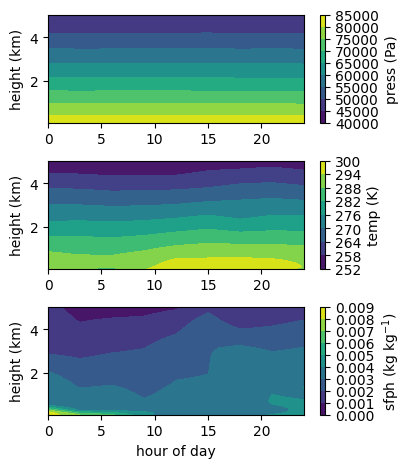

In [11]:
fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(4,5))
for i,(var,l) in enumerate(zip([press_Pa_interp,temp_K_interp,spfh_kg_kg_interp],['press (Pa)','temp (K)',r'sfph (kg kg$^{-1}$)'])):
    im = axs[i].contourf(hrrr['itime'],z_m/1000.,var.T)
    axs[i].set_ylabel('height (km)')
    fig.colorbar(im).set_label(l)

axs[-1].set_xlabel('hour of day')
plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.95, hspace=0.35, wspace=0.3)

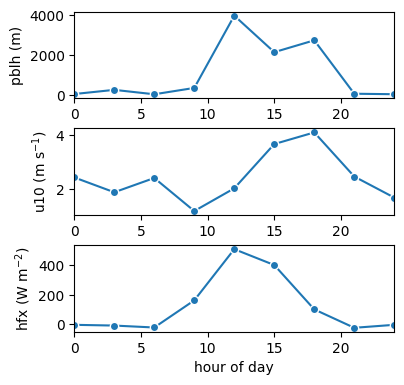

In [12]:
fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(4,4))

for i,var in enumerate(['pblh_m','u10_m_s','hfx_W_m2']):
    axs[i].plot(hrrr['itime'],hrrr[var],'o-',mec='w',mew=1)
    axs[i].set_xlim([0,24])

axs[-1].set_xlabel('hour of day')
axs[0].set_ylabel('pblh (m)')
axs[1].set_ylabel(r'u10 (m s$^{-1}$)')
axs[2].set_ylabel(r'hfx (W m$^{-2}$)')
plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.95, hspace=0.35, wspace=0.3)

<br>
<br>
<br>

---


8. Now we will calculate the height-dependent turbulent diffusivity (Kz) using the HRRR outputs! This is covered in all meterorology textbooks. I'm primarily using Stuff et al (2023).<br>
There are many ways to calculate Kz and the approach I adopted here is fairly basic. The key is to solve friction velocity (u*) and Obukhov length (L) numerically because their formulations depend on each other and the analytical solution isn't easy to get by hand.<br>
Here a Newton method is developped to solve that iteratively.

L=-141.30m, u*=0.72m/s, 7 iterations, z/L error: 8.59e-04
L=-1172.56m, u*=0.67m/s, 6 iterations, z/L error: 1.59e-05
L=2227.19m, u*=0.66m/s, 5 iterations, z/L error: 1.15e-04


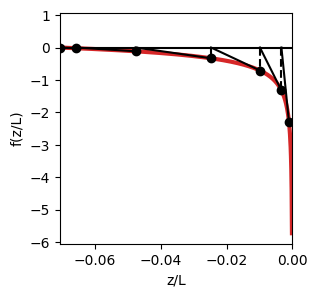

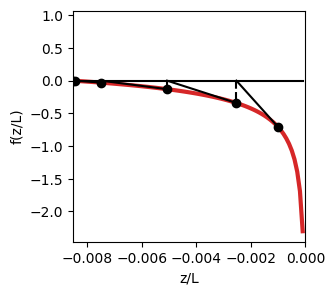

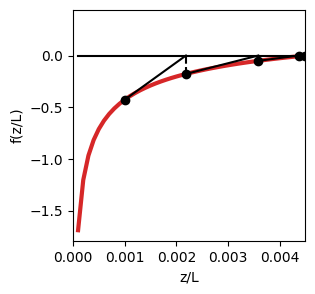

In [13]:
def PSI(zol):
    if zol>=0:  return -4.7*zol  # stable
    else:                        # unstable
        x = (1.-15.*zol)**0.25
        return 2.*np.log(0.5*(1+x))+np.log(0.5*(1+x*x))-2.*np.arctan(x)+np.pi/2.

def phi(zol):
    if zol>=0: return 1.+4.7*zol     # stable or neutral
    else: return (1.-15.*zol)**-0.5  # unstable

def func_ustar(in_uref, in_zref, in_z0, in_zol):
    return 0.4*in_uref/(np.log(in_zref/in_z0)-PSI(in_zol))

def func_ustar_L(in_zol,in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp):
    ustar_from_L = (-1*(in_zref/in_zol)*0.4*9.8*in_hfx/in_rho/in_Cp/in_temp)**(1./3.)
    return func_ustar(in_uref, in_zref, in_z0, in_zol)-ustar_from_L

def func_ustar_L_tengent(in_tolerance,in_zol,in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp):
    dx = 0.01*in_tolerance
    y0 = func_ustar_L(in_zol,in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp)
    y1 = func_ustar_L(in_zol+dx,in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp)
    return (y1-y0)/dx

def func_line(in_x, in_k, in_x0, in_y0): return in_x*in_k-in_k*in_x0+in_y0

# ===========================================================
# Newton solver to solve friction velocity and Obukhov length
# ===========================================================
def solve_zol(in_tolerance,in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp, in_diagnoze_plot=False):
    if in_hfx>=0: initial_guess = -1.*in_tolerance
    else: initial_guess = in_tolerance

    if in_diagnoze_plot:
        plt.figure(figsize=(3,3))
        if in_hfx>=0: test_zol = np.arange(-1,0,in_tolerance*0.1)
        else: test_zol = np.arange(in_tolerance*0.1,1,in_tolerance*0.1)
    if in_diagnoze_plot: test_f = [func_ustar_L(zol,in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp) for zol in test_zol]
    if in_diagnoze_plot: plt.plot(test_zol,test_f,'C3-',lw=3)
    if in_diagnoze_plot: plt.plot(test_zol,np.zeros(len(test_zol)),'k-')

    iter = 0
    iter_max = 15
    y_at_guess = func_ustar_L(initial_guess,in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp)

    while (abs(y_at_guess)>in_tolerance) & (iter<iter_max):
        if iter==0: next_guess = initial_guess
        else: next_guess = (slope*next_guess - y_at_guess)/slope
        slope = func_ustar_L_tengent(in_tolerance,next_guess,in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp)
        y_at_guess = func_ustar_L(next_guess,in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp)
        if (iter!=0) & (in_diagnoze_plot): plt.plot([next_guess,next_guess],[0,y_at_guess],'k--')
        if in_diagnoze_plot: test_zol = np.linspace(next_guess,(slope*next_guess - y_at_guess)/slope)
        if in_diagnoze_plot: plt.plot(test_zol,func_line(test_zol, slope, next_guess, y_at_guess),'k-')
        if in_diagnoze_plot: plt.plot(next_guess,y_at_guess,'ko')
        # print(iter, abs(y_at_guess))
        iter += 1

    if in_diagnoze_plot:
        plt.xlabel('z/L')
        plt.ylabel('f(z/L)')
        if next_guess<0: plt.xlim([next_guess,0])
        else: plt.xlim([0,next_guess])

    return in_zref/next_guess, func_ustar(in_uref, in_zref, in_z0, next_guess), iter, abs(y_at_guess)



in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp = 5., 10., 0.5, 200., 1., 1005., 298.
L, ustar, iter, err = solve_zol(1e-3,in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp, in_diagnoze_plot=True)
print('L=%.2fm, u*=%.2fm/s, %d iterations, z/L error: %.2e' % (L, ustar, iter, err))


in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp = 5., 10., 0.5, 20., 1., 1005., 298.
L, ustar, iter, err = solve_zol(1e-3,in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp, in_diagnoze_plot=True)
print('L=%.2fm, u*=%.2fm/s, %d iterations, z/L error: %.2e' % (L, ustar, iter, err))


in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp = 5., 10., 0.5, -10., 1., 1005., 298.
L, ustar, iter, err = solve_zol(1e-3,in_uref,in_zref,in_z0,in_hfx,in_rho,in_Cp,in_temp, in_diagnoze_plot=True)
print('L=%.2fm, u*=%.2fm/s, %d iterations, z/L error: %.2e' % (L, ustar, iter, err))

9. Now we use the Newton solver to calculate Obukhov length and friction velocity, which are then used to calculate Kz.

<ipython-input-14-14624ee4e6e0>:12: RuntimeWarning: invalid value encountered in power
  kz_m2_s = 0.4*ustar*z_interface_m*((1.-z_interface_m/hrrr['pblh_m'].values[i])**1.5)/phi(zref/L_Obukhov)


-3.0 779.6540062030685
-8.0 89.72360590981444
-21.0 52.907624448192976
162.0 -8.327425544971275
507.0 -10.54696171358703
400.0 -37.575687576690775
101.0 -142.3680323009508
-23.0 47.400785990576324
-3.0 228.7864058446276


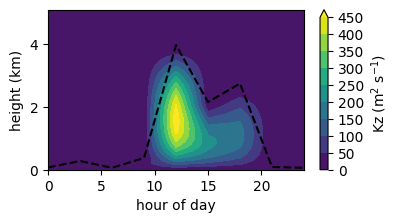

In [14]:
zref = 10.               # reference height
z0 = 0.5                 # roughness
Cp_J_kg_K = 1005         # heat capacity
kz_min_m2_s = 0.01

kz_m2_s_interp = []
for i in range(len(hrrr['itime'])):
    rho_air_kg_m3 = press_Pa_interp[i,0]*28/8.314/temp_K_interp[i,0]/1000.
    L_Obukhov, ustar, _, _ = solve_zol(1e-4,hrrr['u10_m_s'].values[i],zref,z0,
                                       hrrr['hfx_W_m2'].values[i],
                                       rho_air_kg_m3,Cp_J_kg_K,temp_K_interp[i,0],in_diagnoze_plot=False)
    kz_m2_s = 0.4*ustar*z_interface_m*((1.-z_interface_m/hrrr['pblh_m'].values[i])**1.5)/phi(zref/L_Obukhov)
    kz_m2_s = np.where(np.isnan(kz_m2_s),kz_min_m2_s,kz_m2_s)
    kz_m2_s = np.where(kz_m2_s>=kz_min_m2_s, kz_m2_s, kz_min_m2_s)
    kz_m2_s_interp.append(kz_m2_s)
    print(hrrr['hfx_W_m2'].values[i], L_Obukhov)

kz_m2_s_interp = np.array(kz_m2_s_interp)

fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(4,2))
im = axs.contourf(hrrr['itime'],z_interface_m/1000.,kz_m2_s_interp.T, np.arange(0,500,50),extend='max')
fig.colorbar(im).set_label(r'Kz (m$^2$ s$^{-1}$)')

axs.plot(hrrr['itime'],hrrr['pblh_m'].values/1000.,'k--')

axs.set_ylabel('height (km)')
axs.set_xlabel('hour of day')
plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.95, hspace=0.35, wspace=0.3)

np.int32(24)

10. Now we'll create a few diurnal scaling factors which will be used to scale emissions (biogenic and anthropogenic) and solar zenith angle (SZA). <br>
First, the HRRR sensible heat flux is used as a "typical" diurnal profile shape, which remains low at night and peaks at around noon. This will be used for biogenic emissions and SZA.<br>
Second, in a typical urban setting, manny anthropogenic emissions will follow traffic which has two rush hour peaks, one in the morning and the other in the afternoon. So I just made up a profile for that...

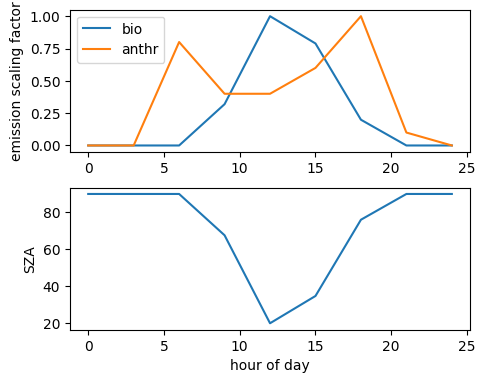

In [15]:
# --- diurnal profile that scales with HRRR sensible heat flux
#     use this for SZA and biogenic emissions
hrrr_diurnal_shape = hrrr['hfx_W_m2'].values/np.nanmax(hrrr['hfx_W_m2'].values)
hrrr_diurnal_shape = np.where((hrrr['itime']<=6) | (hrrr['itime']>=21), 0., hrrr_diurnal_shape)

# --- diurnal profile I made up!!! to reflect morning and afternoon traffic rush hours
#     use this for anthropogenic emissions
anthro_diurnal_shape = [0,0,0.8,0.4,0.4,0.6,1,0.1,0]

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(5,4))
axs[0].plot(hrrr['itime'],hrrr_diurnal_shape,label='bio')
axs[0].plot(hrrr['itime'],anthro_diurnal_shape,label='anthr')
axs[1].plot(hrrr['itime'],90.-70.*hrrr_diurnal_shape)
axs[0].legend(loc='upper left')
axs[1].set_xlabel('hour of day')
axs[0].set_ylabel('emission scaling factor')
axs[1].set_ylabel('SZA')
plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.95, hspace=0.25, wspace=0.25)

11. Finally the main model!!!

In [16]:
start_time = time.time()

# ===================================================================
# this calculates the derivatives: dC/dt
# I'm using eval() to get the derivatives from the string expressions
# ===================================================================
def dcodt(t,conc):
    rate = np.zeros(n_reaction)
    dcodt_out = np.zeros(n_spc)
    for n in range(n_reaction): rate[n] = eval(rates_2eval_compiled[n])
    for n in range(n_spc): dcodt_out[n] = eval(derivatives_2eval_compiled[n])
    # dcodt_out[species_list.index('OH')] = 0.0
    # dcodt_out[species_list.index('CH3O2')] = 0
    # dcodt_out[species_list.index('NO')] += EmisRate_NO_molec_cm3_s
    return dcodt_out  # np.reshape(dcodt_out, (int(n_spc/n_vec_col),n_vec_col))

# ================================
# this calculates jacobian matrix
# will drastically speed things up
# ================================
def jac(t,conc):
    jac_out = np.zeros((n_spc,n_spc))
    exec(jac_compiled)
    # jac_out[species_list.index('O3'),species_list.index('O3')] -= DryDepRate_O3_s
    return jac_out

# ==================================================
# this is the explicit scheme for vertical diffusion
# rigid boundaries set at top and bottom
# ==================================================
def vertical_diffusion(nlev,in_dt,in_dz,in_Kz,in_conc_prev):
    out_conc = np.zeros(len(in_conc_prev))
    for i in range(0,nlev):
        if i==0:         # bottom of the model
            out_conc[i] = in_conc_prev[i] + in_dt/in_dz/in_dz*(-in_Kz[i+1]*(in_conc_prev[i]-in_conc_prev[i+1]))
        elif i==-1+nlev:   # top of the model
            out_conc[i] = in_conc_prev[i] + in_dt/in_dz/in_dz*(in_Kz[i]*(in_conc_prev[i-1]-in_conc_prev[i]))
        else:            # all other layers
            out_conc[i] = in_conc_prev[i] + in_dt/in_dz/in_dz*(in_Kz[i]*(in_conc_prev[i-1]-in_conc_prev[i])-in_Kz[i+1]*(in_conc_prev[i]-in_conc_prev[i+1]))
    return out_conc



# ===================
# Model configuration
# ===================
# --- time stamps
total_run_time_days = 2.               # how long you want to run the model?
output_frequency_seconds = 900         # how often do you save the output?
tout_s = np.arange(0,total_run_time_days*86400,output_frequency_seconds)  # output time stamps, unit: second

# ================================
# Which chemical mechanism to use?
# ================================
# in_ChemMech = ChemMech
in_ChemMech = ChemMech_merge
species_list, reactions, rates_2eval, derivatives_2eval, rate_coeff_express_2eval, jac_2eval, RO2_sum_2eval = pre_process(in_ChemMech)
n_spc = len(species_list)             # number of species
n_reaction = len(in_ChemMech.columns) # number of reactions
print('Chemical mechanism: %d species and %d reactions' % (n_spc,n_reaction))
# print('Done processing the mechanism in: %.6f seconds' % (time.time() - start_time))
start_time = time.time()

# --- prepare arrays
rate_coeff = np.zeros(n_reaction)
conc = np.zeros((len(tout_s),nlev,n_spc))                 # this stores the concentrations. unit: molec/cm3
reaction_rates = np.zeros((len(tout_s),nlev,n_reaction))  # this stores the instantaneous rates. unit: molec/cm3/s
conc_init = pd.DataFrame(np.zeros((n_spc,nlev))).T        # initial conditions packed into a dataframe so it's easy to use
press_all = np.zeros((len(tout_s),nlev))
temp_all = np.zeros((len(tout_s),nlev))
H2O_all = np.zeros((len(tout_s),nlev))
pblh_all = np.zeros((len(tout_s)))
conc_init.columns = species_list
dcodt_out = np.zeros(n_spc)
jac_out = np.zeros((n_spc,n_spc))

# --- pre-compile so it's much faster to evaluate later
rates_2eval_compiled = [compile(r, '<string>', 'eval') for r in rates_2eval]
derivatives_2eval_compiled = [compile(r, '<string>', 'eval') for r in derivatives_2eval]
RO2_sum_compiled = compile(RO2_sum_2eval, '<string>', 'exec')
jac_compiled = compile(jac_2eval, '<string>', 'exec')
# RO2_sum_out_compiled = compile(RO2_sum_2eval.split('=')[1].replace('conc[','conc[i,'), '<string>', 'eval')

# --- special kinetics in MCM: this is directly pulled from MCM
k_label = ['KRO2NO','KRO2HO2','KAPHO2','KAPNO','KRO2NO3','KNO3AL','KDEC','KROPRIM','KROSEC','KCH3O2',
           'K298CH3O2','K14ISOM1','KBPAN','KFPAN','KMT01','KMT02','KMT03','KMT04','KMT05','KMT06','KMT07',
           'KMT08','KMT09','KMT10','KMT11','KMT12','KMT13','KMT14','KMT15','KMT16','KMT17','KMT18','KPPN0',
           'KPPNI','KRPPN','FCPPN','NCPPN','FPPN','KBPPN','KNO','KHO2','KRO2','KNO3','KTR','K16ISOM']



# ==============
# User inputs...
# ==============
# --- this is the solar zenith angle for the j-value parameterization (MCM)
SZA = 90. * np.pi / 180.

# --- environmental conditions
temp = temp_K_interp[0,0]
press = press_Pa_interp[0,0]
# RH = 6.
M = press*6.0232E+17/8.314/temp  # air density. molec/cm3
N2,O2 = 0.78*M, 0.21*M
# H2O = ((RH/100.)*6.1078*np.exp(17.269*(temp-273.3)/temp)*100./8.314/temp)*6.0232e+23/1000000.
H2O = H2O_molec_cm3_interp[0,0]
RO2 = 0         # total RO2 concentration (molec/cm3). MCM needs this. not really saved
RO2_ts = []     # this is a MCM thing

# --- grab a few things from the HRRR dataset
hrrr_hour_of_day = hrrr['itime'].values
hrrr_pblh = hrrr['pblh_m'].values

# --- initial condition. need to convert to molec/cm3
conc_init['O3'] = (30.)  *press_Pa_interp[0,:]*(6.0232E+8)/(8.314*temp_K_interp[0,:])
conc_init['CO'] = (80.)  *press_Pa_interp[0,:]*(6.0232E+8)/(8.314*temp_K_interp[0,:])
conc_init['NO'] = (1.)  *press_Pa_interp[0,:]*(6.0232E+8)/(8.314*temp_K_interp[0,:])
conc_init['NO2'] = (1.)  *press_Pa_interp[0,:]*(6.0232E+8)/(8.314*temp_K_interp[0,:])
conc_init['H2O2'] = (2.)  *press_Pa_interp[0,:]*(6.0232E+8)/(8.314*temp_K_interp[0,:])
conc_init['CH4'] = (1800.)  *press_Pa_interp[0,:]*(6.0232E+8)/(8.314*temp_K_interp[0,:])
conc_init['C2H6'] = (1.)  *press_Pa_interp[0,:]*(6.0232E+8)/(8.314*temp_K_interp[0,:])
conc_init['C3H8'] = (0.5)  *press_Pa_interp[0,:]*(6.0232E+8)/(8.314*temp_K_interp[0,:])
conc_init['BENZENE'] = (0.5)  *press_Pa_interp[0,:]*(6.0232E+8)/(8.314*temp_K_interp[0,:])
conc_init['TOLUENE'] = (0.5)  *press_Pa_interp[0,:]*(6.0232E+8)/(8.314*temp_K_interp[0,:])
conc_init['C5H8'] = (0.3)  *press_Pa_interp[0,:]*(6.0232E+8)/(8.314*temp_K_interp[0,:])

# --- emissions and depositions
max_emis_flux_isop_molec_cm2_s = 1e+12
max_emis_flux_NO_molec_cm2_s = 1e+12
max_emis_flux_CO_molec_cm2_s = 2e+12
max_emis_flux_C2H6_molec_cm2_s = 3e+11
max_emis_flux_C3H8_molec_cm2_s = 1e+11
max_emis_flux_benzene_molec_cm2_s = 1e+11
max_emis_flux_toluene_molec_cm2_s = 2e+11
dep_vel_O3_cm_s = 0.2
dep_vel_NO2_cm_s = 0.2

# ========================
# loop over all time steps
# ========================
for i,t in enumerate(tout_s):
    print('%d/%d, t=%dsec' % (i+1, len(tout_s), t))
    # --- set hour of day
    hour_of_day = (t/3600.) % 24.
    hrrr_closest_ind = abs(hrrr_hour_of_day - hour_of_day).argmin()
    hrrr_closest_hour = hrrr_hour_of_day[hrrr_closest_ind]
    if hour_of_day<hrrr_closest_hour:
        hrrr_hour_ind_prev, hrrr_hour_ind_next = hrrr_closest_ind-1, hrrr_closest_ind
    else:
        hrrr_hour_ind_prev, hrrr_hour_ind_next = hrrr_closest_ind, hrrr_closest_ind+1
    # --- fr is used to interpolate two closest HRRR timesteps to the current timestamp...
    #     current = prev*(1-fr) + next*fr
    fr = (hour_of_day-hrrr_hour_of_day[hrrr_hour_ind_prev])/(hrrr_hour_of_day[hrrr_hour_ind_next]-hrrr_hour_of_day[hrrr_hour_ind_prev])
    # --- interpolate the eddy diffusivity to the local timestamp
    kz_m2_s = kz_m2_s_interp[hrrr_hour_ind_prev,:]*(1.-fr) + kz_m2_s_interp[hrrr_hour_ind_next,:]*fr
    # --- interpolate the emission scaling factors (bio and anthro) to the local timestamp
    hrrr_diurnal_current_hr = (hrrr_diurnal_shape[hrrr_hour_ind_prev]*(1.-fr) + hrrr_diurnal_shape[hrrr_hour_ind_next]*fr)
    anthro_diurnal_current_hr = (anthro_diurnal_shape[hrrr_hour_ind_prev]*(1.-fr) + anthro_diurnal_shape[hrrr_hour_ind_next]*fr)
    # --- set up SZA
    SZA = (90.-70.*hrrr_diurnal_current_hr)* np.pi / 180.
    # --- get PBLH at local timestamp. not really used in the model; archiving only
    pblh_all[i] = (hrrr_pblh[hrrr_hour_ind_prev]*(1.-fr) + hrrr_pblh[hrrr_hour_ind_next]*fr)

    # ===========================
    # run chemistry at each level
    # ===========================
    for ilev in range(len(z_m)):
        # --- set environmental conditions
        temp = temp_K_interp[hrrr_hour_ind_prev,ilev]*(1.-fr) + temp_K_interp[hrrr_hour_ind_next,ilev]*fr
        press = press_Pa_interp[hrrr_hour_ind_prev,ilev]*(1.-fr) + press_Pa_interp[hrrr_hour_ind_next,ilev]*fr
        H2O = H2O_molec_cm3_interp[hrrr_hour_ind_prev,ilev]*(1.-fr) + H2O_molec_cm3_interp[hrrr_hour_ind_next,ilev]*fr
        M = press*6.0232E+17/8.314/temp  # air density. molec/cm3
        N2,O2 = 0.78*M, 0.21*M
        press_all[i,ilev] = press
        temp_all[i,ilev] = temp
        H2O_all[i,ilev] = H2O
        # --- set emissions and depositions: only in the bottom layer
        if ilev==0:
            emission_rate_isoprene_molec_cm3_s = max_emis_flux_isop_molec_cm2_s*hrrr_diurnal_current_hr/(dz_m*100.)
            emission_rate_NO_molec_cm3_s = max_emis_flux_NO_molec_cm2_s*anthro_diurnal_current_hr/(dz_m*100.)
            emission_rate_CO_molec_cm3_s = max_emis_flux_CO_molec_cm2_s*anthro_diurnal_current_hr/(dz_m*100.)
            emission_rate_C2H6_molec_cm3_s = max_emis_flux_C2H6_molec_cm2_s*anthro_diurnal_current_hr/(dz_m*100.)
            emission_rate_C3H8_molec_cm3_s = max_emis_flux_C3H8_molec_cm2_s*anthro_diurnal_current_hr/(dz_m*100.)
            emission_rate_benzene_molec_cm3_s = max_emis_flux_benzene_molec_cm2_s*anthro_diurnal_current_hr/(dz_m*100.)
            emission_rate_toluene_molec_cm3_s = max_emis_flux_toluene_molec_cm2_s*anthro_diurnal_current_hr/(dz_m*100.)
            dep_rate_O3_sec = dep_vel_O3_cm_s/(dz_m*100.)
            dep_rate_NO2_sec = dep_vel_NO2_cm_s/(dz_m*100.)
        else:
            emission_rate_isoprene_molec_cm3_s = 0.
            emission_rate_CO_molec_cm3_s = 0.
            emission_rate_NO_molec_cm3_s = 0.
            emission_rate_C2H6_molec_cm3_s = 0.
            emission_rate_C3H8_molec_cm3_s = 0.
            emission_rate_benzene_molec_cm3_s = 0.
            emission_rate_toluene_molec_cm3_s = 0.
            dep_rate_O3_sec = 0.
            dep_rate_NO2_sec = 0.
        # --- update photolysis frequencies
        jval = mcm_jval(SZA)
        # --- update generic rate coefficients
        if ('HO2' in species_list) & ('NO' in species_list):
            mcm_kinetics = pd_mcm_kinetics(temp,M,N2,O2,H2O,
                                        conc[max(i-1,0),ilev,species_list.index('NO')], # only needed for K16ISOM
                                        conc[max(i-1,0),ilev,species_list.index('HO2')], RO2)
        else: mcm_kinetics = pd_mcm_kinetics(temp,M,N2,O2,H2O)
        for k in k_label: exec("%s = np.array(mcm_kinetics['%s'])[0]" % (k,k))
        # --- need to update all environmental variables, mcm kinetics, jval before eval()
        for n in range(n_reaction): rate_coeff[n] = eval(rate_coeff_express_2eval[n])
        # --- now solve the ODE. Use BDF since it's mostly stiff
        #     accuracy controlled by relative/absolute tolerance (rtol,atol)
        #     integrate step by step, since some env variables may change over the course of time
        # rate_coeff[32] = 0.   # NA production. This is a MCM thing...
        # rate_coeff[33] = 0.   # NA production. This is a MCM thing...
        if i==0: conc[i,:,:] = conc_init
        else: conc[i,ilev,:] = solve_ivp(dcodt,tout_s[0:2],conc[i-1,ilev,:],t_eval=[output_frequency_seconds],
                                    jac=jac, method='BDF', rtol=1e-4,atol=1e+3).y[:,0]
        # --- get instantaneous rates. unit: molec/cm3/s
        for n_reac,reaction in enumerate(reactions):
            reactants = reaction.split(' = ')[0].split(' + ')
            # --- 20250407: add support for zero-order reactions
            if len(''.join(reactants).replace(' ',''))!=0:
                spc_ind = [species_list.index(spc.replace(' ','')) for spc in reactants]
                rate_temp = rate_coeff[n_reac]
                for ind in spc_ind: rate_temp = rate_temp * conc[i,ilev,ind]
                reaction_rates[i,ilev,n_reac] = rate_temp
            else:
                reaction_rates[i,ilev,n_reac] = rate_coeff[n_reac]
        # # --- get total RO2
        # RO2 = eval(RO2_sum_out_compiled)
        # RO2_ts.append(RO2)
        # print('O3: %.2e' % (conc['O3'][-1+len(tout_s)]))

    # =========================
    # now do vertical diffusion
    # =========================
    dt_diffusion = 0.4 * dz_m**2. / np.nanmax(kz_m2_s)
    if output_frequency_seconds>dt_diffusion:
        N_split_step_diffusion = int(np.ceil(output_frequency_seconds/dt_diffusion))
        dt_split_diffusion = output_frequency_seconds/N_split_step_diffusion
        print('*** Warning. Instable diffusion. Current dt=%.1fs. Recommend dt=%.1fs' % (output_frequency_seconds, dt_diffusion))
        print('    Diffusion will be split into %d chunks, each has a smaller time step of %.1fs' % (N_split_step_diffusion, dt_split_diffusion))
    for ispc in range(len(species_list)):
        # --- if time step is too big, may cause stability issues
        #     chop into smaller steps
        if output_frequency_seconds>dt_diffusion:
            tot_diffusion_timestep = 0
            for isplit in range(N_split_step_diffusion):
                conc[i,:,ispc] = vertical_diffusion(nlev,dt_split_diffusion,dz_m,kz_m2_s,conc[i,:,ispc])
                tot_diffusion_timestep += dt_split_diffusion
        else:
            conc[i,:,ispc] = vertical_diffusion(nlev,output_frequency_seconds,dz_m,kz_m2_s,conc[i,:,ispc])

# ====================================================================
# pack the concentrations and a few other things into a xarray dataset
# ====================================================================
out_conc = xr.Dataset(coords={'time': tout_s,
                             'height': z_m, })
out_conc['time'].attrs = {'long name':'exactly what it looks like', 'unit':'second'}
out_conc['height'].attrs = {'long name':'height at layer center', 'unit':'meter'}
out_conc['press'] = (('time', 'height'), press_all)
out_conc['temp'] = (('time', 'height'), temp_all)
out_conc['H2O'] = (('time', 'height'), H2O_all)
out_conc['pblh'] = (('time'), pblh_all)
out_conc['press'].attrs = {'unit':'Pa'}
out_conc['temp'].attrs = {'unit':'K'}
out_conc['H2O'].attrs = {'unit':'molec/cm3'}
out_conc['pblh'].attrs = {'unit':'m'}
for spc in species_list:
    out_conc[spc] = (('time', 'height'), conc[:,:,species_list.index(spc)])
    out_conc[spc].attrs = {'unit':'molec/cm3'}

out_conc

# conc = pd.DataFrame(conc)
# conc.columns = species_list
# conc['total_RO2'] = RO2_ts
# conc['NOx'] = conc['NO']+conc['NO2']

# # --- pack the rate outputs (in molec/cm3/s) into a DataFrame
# reaction_rates = pd.DataFrame(reaction_rates)
# reaction_rates.columns = in_ChemMech.columns

wrapup_str = 'YAMCHA: Yet Another Model for Chemistry Happening in the Air\n'
wrapup_str = '1D version. %d vertical layers, layer thickness %d m\n' % (nlev, dz_m)
wrapup_str = wrapup_str + 'Total run time: %.2f days (%.2f hours)\n' % (total_run_time_days, total_run_time_days*24)
wrapup_str = wrapup_str + 'Output frequency: %.2f seconds | %d steps\n' % (output_frequency_seconds, total_run_time_days*86400/output_frequency_seconds)
wrapup_str = wrapup_str + 'Time elapsed: %.6f seconds' % (time.time() - start_time)
print( wrapup_str )

# for s in ['CH4','O3']:
#     plt.plot(tout_s,conc[s]/(press*(6.0232E+8)/(8.314*temp)),'.-',label=s)
#     # plt.yscale('log')
# plt.xlabel('time (second)')
# plt.ylabel('conc (ppb)')
# plt.legend()
# plt.show()

Chemical mechanism: 136 species and 434 reactions
1/192, t=0sec
2/192, t=900sec
3/192, t=1800sec
4/192, t=2700sec
5/192, t=3600sec
6/192, t=4500sec
7/192, t=5400sec
8/192, t=6300sec
9/192, t=7200sec
10/192, t=8100sec
11/192, t=9000sec
12/192, t=9900sec
13/192, t=10800sec
14/192, t=11700sec
15/192, t=12600sec
16/192, t=13500sec
17/192, t=14400sec
18/192, t=15300sec
19/192, t=16200sec
20/192, t=17100sec
21/192, t=18000sec
22/192, t=18900sec
23/192, t=19800sec
24/192, t=20700sec
25/192, t=21600sec
26/192, t=22500sec
27/192, t=23400sec
*** Warning. Instable diffusion. Current dt=900.0s. Recommend dt=808.2s
    Diffusion will be split into 2 chunks, each has a smaller time step of 450.0s
28/192, t=24300sec
*** Warning. Instable diffusion. Current dt=900.0s. Recommend dt=539.1s
    Diffusion will be split into 2 chunks, each has a smaller time step of 450.0s
29/192, t=25200sec
*** Warning. Instable diffusion. Current dt=900.0s. Recommend dt=404.5s
    Diffusion will be split into 3 chunks, e

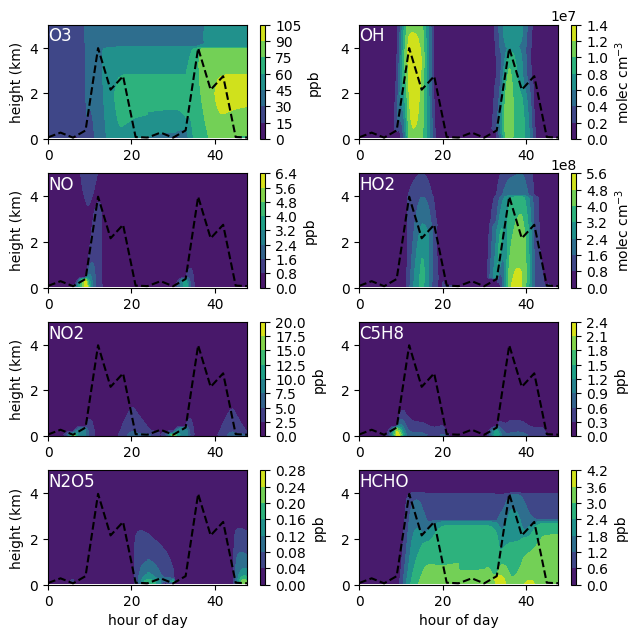

In [17]:
nrols,ncols = 4,2
fig, axs = plt.subplots(nrows=nrols,ncols=ncols,figsize=(7,7))
for n,spc in enumerate(['O3','NO','NO2','N2O5','OH','HO2','C5H8','HCHO']):
    i,j = n%nrols, int(n/nrols)
    conc2mr = (out_conc['press']*(6.0232E+8)/(8.314*out_conc['temp']))
    axs[i,j].set_title(spc,fontsize=12,color='w',x=0,y=0.75,ha='left',va='bottom')
    if (spc=='OH') | (spc=='HO2'):
        im = axs[i,j].contourf(tout_s/3600.,z_m/1000.,out_conc[spc].T,vmin=0)
        fig.colorbar(im).set_label(r'molec cm$^{-3}$')
    else:
        im = axs[i,j].contourf(tout_s/3600.,z_m/1000.,out_conc[spc].T/conc2mr)
        fig.colorbar(im).set_label('ppb')
    if i==nrols-1: axs[i,j].set_xlabel('hour of day')
    if j==0: axs[i,j].set_ylabel('height (km)')
    axs[i,j].plot(tout_s/3600.,out_conc['pblh']/1000.,'k--')
    # axs[i,j].set_xlim([0,48])
    axs[i,j].set_ylim([0,5])
plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.95, hspace=0.3, wspace=0.25)

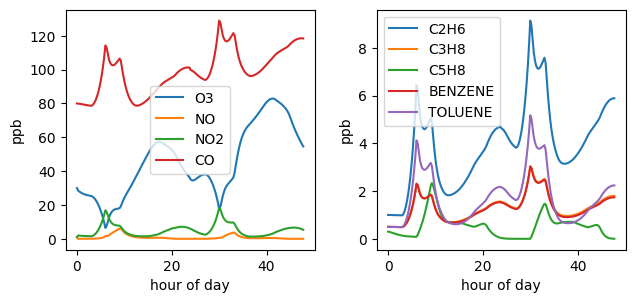

In [23]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(7,3))
ilev = 0
for spc in ['O3','NO','NO2','CO']:
    axs[0].plot(tout_s/3600., out_conc[spc][:,ilev] /(out_conc['press'][:,ilev]*(6.0232E+8)/(8.314*out_conc['temp'][:,ilev])),'-',label=spc)
for spc in ['C2H6','C3H8','C5H8','BENZENE','TOLUENE']:
    axs[1].plot(tout_s/3600., out_conc[spc][:,ilev] /(out_conc['press'][:,ilev]*(6.0232E+8)/(8.314*out_conc['temp'][:,ilev])),'-',label=spc)
for ax in axs:
    ax.set_xlabel('hour of day')
    ax.set_ylabel('ppb')
    ax.legend()
#     if j==0: axs[i,j].set_ylabel('height (km)')
#     axs[i,j].plot(tout_s/3600.,out_conc['pblh']/1000.,'k--')
#     # axs[i,j].set_xlim([0,48])
#     axs[i,j].set_ylim([0,5])
plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.95, hspace=0.3, wspace=0.25)


# ilev = 0
# for spc in ['O3','NO','NO2','N2O5','CO']:
#     plt.plot(tout_s/3600., out_conc[spc][:,ilev] /(out_conc['press'][:,ilev]*(6.0232E+8)/(8.314*out_conc['temp'][:,ilev])),'.-',label=spc)
# plt.legend()
# plt.xlabel('hour of day')
# plt.ylabel('ppb')
# plt.show()

# ilev = 0
# for spc in ['C2H6','C3H8','C5H8','BENZENE','TOLUENE']:
#     plt.plot(tout_s/3600., out_conc[spc][:,ilev] /(out_conc['press'][:,ilev]*(6.0232E+8)/(8.314*out_conc['temp'][:,ilev])),'.-',label=spc)
# plt.legend()
# plt.xlabel('hour of day')
# plt.ylabel('ppb')
# plt.show()

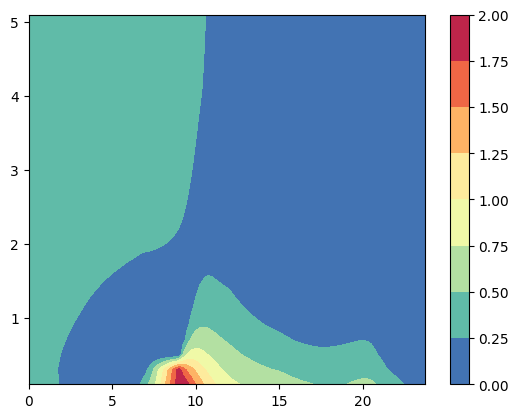

In [ ]:
plt.contourf(tout_s/3600., z_m/1000., out_conc['C5H8'].T /(out_conc['press']*(6.0232E+8)/(8.314*out_conc['temp'])),cmap='Spectral_r')
plt.colorbar()